# Modellare il cambiamento nel tempo {#sec-change-across-time}

**Prerequisiti**

- Leggere *A Tutorial on Bayesian Modeling of Change Across Time, Individuals, and Groups* di @knight2023tutorial.

**Concetti e competenze chiave**

- Comprendere la nozione di un modello che descrivono processi che cambiano nel tempo e la sua importanza nella spiegazione del comportamento umano.
- Sapere implementare e interpretare l'approccio bayesiano per modellare processi dinamici così come discusso da @knight2023tutorial.
- Saper implementare e interpretare il modello di @knight2023tutorial che stima i parametri medi per un intero campione di partecipanti.
- Comprendere come modellare i processi per ogni individuo separatamente, catturando la variabilità tra i partecipanti così come discusso da @knight2023tutorial.
- Saper combinare i modelli a livello di campione e a livello individuale in un unico framework, per fare inferenze sia a livello individuale che di popolazione, così come discusso da @knight2023tutorial.
- Saper utilizzare criteri come l'ELPD e i valori di Pareto $k$ per valutare la qualità del modello e la sua capacità di rappresentare i dati empirici.

**Preparazione del Notebook**

In [1]:
import os
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import bambi as bmb
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import warnings

warnings.simplefilter(action="ignore")

In [2]:
seed: int = sum(map(ord, "stan_knight2023"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(home_directory, '_repositories', 'psicometria')

## Introduzione

L'obiettivo di questo capitolo è introdurre i modelli che descrivono i processi dinamici, seguendo un tutorial proposto da @knight2023tutorial. In molti ambiti della psicologia, come la psicologia sociale, dello sviluppo, clinica e organizzativa, si studiano fenomeni che cambiano nel tempo e sono quindi dinamici. Tuttavia, questi processi dinamici sono spesso difficili da osservare o misurare direttamente, poiché possono essere il risultato di diverse combinazioni di processi che si manifestano in modi variabili a seconda del contesto e delle persone coinvolte. Inoltre, i processi dinamici possono operare su diversi livelli e svilupparsi su scale temporali differenti.

Per verificare una teoria dinamica, un ricercatore deve adottare un disegno di ricerca longitudinale che consenta di osservare i processi psicologici nel loro sviluppo nel tempo, e utilizzare un modello statistico che traduca in termini operativi i processi descritti dalla teoria. Un approccio particolarmente utile per modellare i processi dinamici è l'approccio bayesiano, che offre maggiore flessibilità rispetto ad altre alternative, come i modelli di curve di crescita latenti e i modelli di punteggi dei cambiamento latenti, nei quali la complessità aumenta drasticamente con l'aumentare del numero di variabili e dei punti temporali.

La flessibilità di questo approccio consente di costruire modelli statistici che si allineano più direttamente alla teoria psicologica. Ciò permette una connessione più stretta tra teoria e modello, e consente una verifica più chiara della teoria stessa.

## Comprendere i Processi Dinamici

I processi dinamici sono solitamente rappresentati come sistemi a ciclo chiuso, in cui gli output del sistema influenzano gli input, determinando così cambiamenti continui nei componenti del sistema nel tempo. Una caratteristica fondamentale di un processo dinamico è che almeno una delle variabili mantiene una "memoria" del suo valore nei momenti temporali precedenti. Questo tipo di variabile, spesso chiamata "variabile dinamica", cambia il suo valore nel tempo in modo coerente con il suo stato passato. Può aumentare o diminuire, ma non può assumere valori che sarebbero incompatibili o illogici rispetto al suo stato precedente.

I modelli bayesiani che descrivono i processi dinamici sono spesso utilizzati in psicologia cognitiva. Questi includono modelli di apprendimento per rinforzo, che catturano come le persone interagiscono con l'ambiente per massimizzare la ricompensa cumulativa, e modelli di diffusione, che rappresentano come le persone prendono decisioni rapide.

Nel loro tutorial, @knight2023tutorial utilizzano un esempio di regolazione degli obiettivi per illustrare un processo dinamico rilevante in molte aree della psicologia. La regolazione degli obiettivi è un meccanismo attraverso il quale le persone valutano e modificano i loro obiettivi nel tempo, basandosi sulle loro performance passate.

Per spiegare il processo dinamico di regolazione degli obiettivi, vengono utilizzati dati reali provenienti da uno studio di simulazione del controllo del traffico aereo condotto da @gee2018formal. In questo studio, 60 partecipanti hanno completato dieci prove di 10 minuti ciascuna, durante le quali dovevano classificare coppie di aeromobili come in conflitto o non in conflitto in base alla loro distanza minima di separazione. Prima di ogni prova, i partecipanti fissavano un obiettivo riguardo al numero di coppie di aeromobili che intendevano classificare correttamente o erroneamente. L'obiettivo dello studio era esaminare come le persone rivedessero i loro obiettivi nel tempo sulla base delle loro performance.

Il modello utilizzato per descrivere questo processo predice che una persona modifica il proprio obiettivo in funzione della discrepanza tra l'obiettivo precedente e la performance ottenuta. Questo modello incorpora una componente auto-regressiva che conserva una "memoria" del passaggio temporale precedente. Formalmente, il processo è descritto dall'equazione:

$$
G_t = G_{t-1} + \alpha(P_{t-1} - G_{t-1}) + \beta,
$$

dove $G$ rappresenta il livello dell'obiettivo e $P$ la performance effettiva. Il parametro $\alpha$ rappresenta il tasso di apprendimento: valori più alti di $\alpha$ indicano che la revisione dell'obiettivo è più sensibile alla discrepanza tra l'obiettivo precedente e la performance precedente. Il parametro $\beta$ rappresenta un aggiustamento dell'obiettivo che avviene indipendentemente dalla discrepanza tra obiettivo e performance.

Per rappresentare adeguatamente questo modello, è necessario considerare il livello dell'obiettivo come una variabile dinamica che conserva una "memoria" del suo stato precedente. Questo tipo di processo dinamico è complesso da rappresentare utilizzando approcci statistici tradizionali, ma è facilmente implementabile all'interno del framework bayesiano.

Questa struttura dinamica è concettualmente simile a un modello di Markov di primo ordine, come quello descritto in precedenza. Nel modello di Markov discusso nel @sec-post-error, la probabilità di commettere un errore alla prova attuale ($y[n]$) dipende esclusivamente dallo stato immediatamente precedente ($y[n-1]$), caratterizzandolo come un processo senza memoria a lungo termine ma con dipendenza temporale di primo ordine.

Entrambi i modelli condividono l'idea di dipendenza dal passato immediato: nel modello dinamico utilizzato da @gee2018formal, l'obiettivo viene aggiornato in base alla discrepanza tra l'obiettivo e la performance passata, mentre nel modello di Markov del @sec-post-error la probabilità di errore successivo è determinata dallo stato dell'errore precedente. In entrambi i casi, le transizioni sono influenzate solo dallo stato o dalla condizione immediatamente precedente, una caratteristica fondamentale dei processi di Markov di primo ordine. Tuttavia, mentre il modello del @sec-post-error considera esclusivamente uno stato binario (errore o non errore), il modello dinamico attuale prende in considerazione una variabile continua e la discrepanza tra obiettivo e performance, permettendo una rappresentazione più dettagliata dei cambiamenti nel comportamento.

Iniziamo ad importare i dati dello studio di @gee2018formal.

In [3]:
data_file = os.path.join(project_directory, "data", "goal_data.csv")
goal_data = pd.read_csv(data_file)
goal_data.head()

,subject,condition,goal,performance,trial
0,1,approach,2,0,1
1,1,approach,2,2,2
2,1,approach,2,2,3
3,1,approach,4,4,4
4,1,approach,4,2,5


Calcoliamo alcune statistiche descrittive.

In [4]:
# Numero totale di prove
num_trials = len(goal_data)

# Numero di atleti unici
num_subj = goal_data["subject"].nunique()

# Stampa dei risultati
print(f"Numero totale di prove: {num_trials}")
print(f"Numero di partecipanti: {num_subj}")

Numero totale di prove: 600
Numero di partecipanti: 60


Organizziamo i dati in un dizionario nel formato richiesto da Stan per i modelli presentati da @knight2023tutorial, che discuteremo qui.

In [23]:
stan_data = {
    "subject": goal_data["subject"].tolist(),
    "condition": pd.factorize(goal_data["condition"])[0]
    + 1,  # 1 = approach, 2 = avoidance
    "observed_goal": goal_data["goal"].tolist(),
    "trial": goal_data["trial"].tolist(),
    "performance": goal_data["performance"].tolist(),
    "Nsubj": goal_data["subject"].nunique(),
    "Ntotal": len(goal_data["subject"]),
}

Analizziamo ogni elemento del dizionario. Questo passaggio ci sarà utile più avanti per comprendere il funzionamento del codice Stan.

In [6]:
# Iterate through each element in the dictionary and print the length and first 15 elements
for key, value in stan_data.items():
    if (
        isinstance(value, list)
        or isinstance(value, pd.Series)
        or isinstance(value, np.ndarray)
    ):
        print(f"{key}: Length = {len(value)}")
        print(f"First 15 elements of {key}: {value[:15]}")
    else:
        print(f"{key}: {value}")

subject: Length = 600
First 15 elements of subject: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
condition: Length = 600
First 15 elements of condition: [1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
observed_goal: Length = 600
First 15 elements of observed_goal: [2, 2, 2, 4, 4, 2, 2, 4, 2, 4, 4, 4, 6, 6, 6]
trial: Length = 600
First 15 elements of trial: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5]
performance: Length = 600
First 15 elements of performance: [0, 2, 2, 4, 2, 0, 4, 2, 4, 4, 3, 5, 7, 5, 6]
Nsubj: 60
Ntotal: 600


## Modello a livello di campione

Il primo modello presentato da @knight2023tutorial è il `1_sample_level_model.stan`. Questo modello include due parametri teoricamente rilevanti: α e β. Per implementare il modello di revisione degli obiettivi come modello statistico, si aggiunge un terzo parametro, σ, che rappresenta la deviazione standard residua del livello degli obiettivi.

Nel modello proposto, questi parametri vengono stimati a livello di campione, ovvero il comportamento dell'intero campione viene descritto utilizzando un unico set di parametri. Il modello assume quindi che il processo di revisione degli obiettivi sia identico per tutti i partecipanti.

Procediamo ora con la compilazione e la stampa del codice Stan di questo modello.

In [54]:
stan_file = os.path.join(
    project_directory, "stan", "change_models", "1_sample_level_model.stan"
)

sample_level_model = CmdStanModel(stan_file=stan_file)
print(sample_level_model.code())

data {
  int<lower=1> Ntotal; //Total number of trials in the dataset (600)
  array[Ntotal] real<lower=1> trial; //Trial number
  array[Ntotal] real observed_goal; //Goal level for each trial
  array[Ntotal] real performance; //Performance for each trial
}
parameters {
  real alpha; //initialize single alpha parameter for entire sample
  real beta; //initialize single beta parameter for entire sample
  real<lower=0> sigma; //initialize single sigma parameter for entire sample and set lower bound at 0.
}
model {
  real predicted_goal; //initialize predicted goal level object to store predictions
  
  //PRIORS
  alpha ~ normal(0, 1); //set weakly informative prior on alpha
  beta ~ normal(0, 1); //set weakly informative prior on beta
  sigma ~ normal(0, 1); //set weakly informative prior on sigma
  
  //LIKELIHOOD
  //loop through all trials in the dataset performing bracketed operations on each one
  for (i in 1 : Ntotal) {
    //if the trial being considered is the first trial for that

Nel modello `1_sample_level_model.stan`, i dati sono rappresentati da una serie di variabili, tra cui il numero totale di prove (`Ntotal`), il numero di ciascuna prova (`trial`), il livello di obiettivo osservato in ciascuna prova (`observed_goal`), e la performance in ciascuna prova (`performance`).

I parametri principali del modello sono `alpha`, `beta` e `sigma`:

- **`alpha`** e **`beta`**: sono parametri a cui vengono assegnate prior distribuzioni normali con media 0 e deviazione standard 1. Questi sono noti come "priori debolmente informativi" perché non esprimono una forte convinzione a priori su una particolare regione dello spazio dei parametri. 
- **`sigma`**: è un altro parametro che rappresenta la deviazione standard residua del livello degli obiettivi. Anche `sigma` ha un priore distribuito normalmente, ma con un vincolo aggiuntivo: deve essere positivo (da qui `real<lower=0> sigma`). Questo significa che l'algoritmo campionerà solo valori positivi da questa distribuzione.

Il "modello" in questo contesto si riferisce alla sequenza di operazioni necessarie per determinare la verosimiglianza dei dati dati i valori campionati dei parametri. Il modello è costruito utilizzando un ciclo `for` che esegue operazioni per ogni punto dati.

- **Ciclo `for`**: La linea `for (i in 1 : Ntotal)` inizializza un ciclo che itera attraverso tutti i punti dati, da 1 fino a `Ntotal`. Durante ogni iterazione, la variabile di ciclo `i` assume il valore dell'indice corrente.
  
  - **Prima prova**: Se `i` rappresenta il primo trial per un soggetto (`trial[i] == 1`), il livello di obiettivo previsto (`predicted_goal`) è impostato uguale all'obiettivo osservato (`observed_goal[i]`). Questo è perché non ci sono prove precedenti per determinare un obiettivo previsto basato sulla performance passata. Questo comportamento è definito alle linee 25-27 del modello.
  - **Prove successive**: Per tutte le prove successive alla prima (`trial[i] > 1`), il livello di obiettivo previsto viene aggiornato secondo una teoria del cambiamento: `predicted_goal` viene incrementato in base alla differenza tra la performance della prova precedente e il livello di obiettivo previsto attuale, aggiungendo anche il parametro `beta` specifico per l'individuo. Questo è implementato alle linee 28-30. L'operatore `+=` aggiorna il valore corrente di `predicted_goal` aggiungendo il risultato del calcolo.

- **Verosimiglianza**: Dopo aver calcolato `predicted_goal`, il modello confronta questo valore con `observed_goal`. La linea 31 utilizza l'operatore `~` per specificare che `observed_goal` è trattato come una variabile dipendente. Qui, si assume che `observed_goal[i]` provenga da una distribuzione normale con una media uguale a `predicted_goal` e una deviazione standard uguale a `sigma`. L'algoritmo quindi valuta la verosimiglianza dell'obiettivo osservato dato i valori attuali dei parametri e aggiorna di conseguenza la distribuzione a posteriori.

In altre parole, il modello effettua una regressione dell'obiettivo osservato sull'obiettivo previsto, fissando l'intercetta a 0 e la pendenza a 1, con `sigma` che rappresenta la deviazione standard residua dell'obiettivo osservato. Questo permette al modello di adattarsi dinamicamente ai dati e di descrivere come gli obiettivi si modificano nel tempo in funzione delle performance passate.

Eseguiamo il campionamento.

In [59]:
fit_sample = sample_level_model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Convertiamo l'oggetto `fit_sample` in un formato compatibile con ArviZ.

In [60]:
fit_sample_az = az.from_cmdstanpy(posterior=fit_sample)

Esaminiamo le distribuzioni a posteriori dei paraemtri.

In [57]:
az.summary(fit_sample_az, var_names=["alpha", "beta", "sigma"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.51,0.03,0.45,0.57,0.0,0.0,6395.60,5448.32,1.0
beta,0.17,0.03,0.11,0.23,0.0,0.0,6646.13,5931.03,1.0
sigma,1.29,0.04,1.22,1.36,0.0,0.0,6400.46,5046.39,1.0


I risultati ottenuti per il modello a livello di campione mostrano i valori stimati per i parametri `alpha`, `beta` e `sigma`:

- **Alpha**: Il valore più probabile per `alpha` si trova nel range tra 0.45 e 0.57, con una media stimata di 0.51. Questo intervallo suggerisce che i tassi di apprendimento si trovano principalmente in questa gamma, indicando che le persone tendono ad aggiornare il loro obiettivo basandosi sulla differenza tra la performance passata e l'obiettivo previsto in modo moderato.
  
- **Beta**: I valori più probabili per `beta` sono compresi tra 0.11 e 0.23, con una media di 0.17. Questo risultato suggerisce che, indipendentemente dalla discrepanza tra l'obiettivo precedente e la performance precedente, le persone tendono ad aumentare il loro obiettivo di una piccola quantità aggiuntiva.

- **Sigma**: La deviazione standard residua `sigma` è stimata con una media di 1.29, con un intervallo credibile del 94% che va da 1.22 a 1.36. Questo parametro rappresenta la variabilità residua nei livelli degli obiettivi osservati che non è spiegata dal modello.

Nel modello attuale, i parametri `alpha` e `beta` rappresentano i valori medi dei parametri per tutti i partecipanti del campione. Questo implica che il modello considera che il processo di revisione degli obiettivi avvenga nello stesso modo per ogni partecipante, utilizzando un unico set di parametri per descrivere il comportamento dell'intero campione. Tuttavia, questo modello non ci fornisce informazioni su come questi parametri possano variare tra i singoli individui. 

Per esaminare le differenze a livello individuale, sarebbe necessario un modello a livello di persona, dove vengono stimati parametri unici per ogni partecipante. Un tale modello permetterebbe di considerare le variazioni individuali, assumendo che il processo di revisione degli obiettivi possa funzionare in modo diverso per ciascuna persona.

## Modello a livello di persona

Un modello a livello di persona è fornito nel codice `2_person_level_model.stan`. Tale modello può essere facilmente implementato apportando alcune modifiche al modello precedente:

1. **Nuove variabili nel blocco dati**: Sono necessarie due nuove variabili: `Nsubj`, che rappresenta il numero totale di partecipanti (ad esempio, `Nsubj = 60`), e `subject`, una colonna di numeri interi che rappresentano il numero del partecipante.
  
2. **Parametri come array**: Nel blocco dei parametri, `alpha` e `beta` devono essere dichiarati come array di dimensione `Nsubj` anziché come valori scalari. Questo implica che ci sarà un parametro `alpha` e un parametro `beta` unici stimati per ogni partecipante, permettendo di modellare la variabilità individuale.

3. **Modifiche nel blocco del modello**: Nel blocco del modello, i parametri `alpha` e `beta` devono essere indicizzati con `subject[i]` per far sì che il punteggio previsto sia calcolato in base ai parametri associati al partecipante i-esimo, in base ai dati situati nella riga i-esima del dataset.

Queste modifiche permettono di passare da un modello che descrive il comportamento medio del campione a uno che può catturare le differenze individuali, fornendo un'analisi più dettagliata e precisa delle dinamiche di revisione degli obiettivi.

In [13]:
stan_file = os.path.join(
    project_directory, "stan", "change_models", "2_person_level_model.stan"
)

person_level_model = CmdStanModel(stan_file=stan_file)
print(person_level_model.code())

data {
  int<lower=0> Ntotal; // Total number of trials in the dataset (600)
  array[Ntotal] int<lower=1> trial; // Trial number
  array[Ntotal] real observed_goal; // Goal level for each trial
  array[Ntotal] real performance; // Performance for each trial
  int<lower=1> Nsubj; // Number of subjects
  array[Ntotal] int<lower=1, upper=Nsubj> subject; // Subject number
}
parameters {
  vector[Nsubj] alpha; // Unique alpha parameter for each subject
  vector[Nsubj] beta; // Unique beta parameter for each subject
  real<lower=0> sigma; // Single sigma parameter for entire sample
}
model {
  vector[Ntotal] predicted_goal; // Vector to store predictions
  
  // Priors
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma ~ normal(0, 1);
  
  // Likelihood
  for (i in 1 : Ntotal) {
    if (trial[i] == 1) {
      predicted_goal[i] = observed_goal[i];
    } else {
      predicted_goal[i] = predicted_goal[i - 1]
                          + alpha[subject[i]]
                            * (perfo

Eseguiamo il campionamento.

In [14]:
fit_person = person_level_model.sample(
    data=stan_data,
    iter_warmup=10_000,
    iter_sampling=20_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Questo modello produce un insieme di campioni posteriori di alpha e beta per ogni partecipante.

In [15]:
fit_person_az = az.from_cmdstanpy(posterior=fit_person)
az.summary(fit_person_az, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.61,0.24,0.16,1.04,0.00,0.00,4791.24,3205.07,1.00
alpha[1],0.19,0.21,-0.21,0.60,0.00,0.00,5696.38,23355.82,1.01
alpha[2],0.14,0.20,-0.21,0.57,0.01,0.01,482.28,131.39,1.01
alpha[3],0.36,0.32,-0.22,0.96,0.01,0.01,1292.01,13071.55,1.00
alpha[4],0.37,0.17,0.05,0.68,0.00,0.00,1673.29,27077.52,1.00
...,...,...,...,...,...,...,...,...,...
sampled_goal[596],6.23,0.96,4.43,8.04,0.01,0.00,25829.93,72786.03,1.00
sampled_goal[597],6.88,0.96,5.07,8.66,0.00,0.00,44329.67,75437.97,1.00
sampled_goal[598],6.40,0.98,4.55,8.23,0.01,0.01,17989.62,68475.72,1.00
sampled_goal[599],6.28,0.98,4.40,8.07,0.01,0.00,19943.05,65972.11,1.00


Esaminiamo le distribuzioni a posteriori dei parametri $\alpha$ e $\beta$.

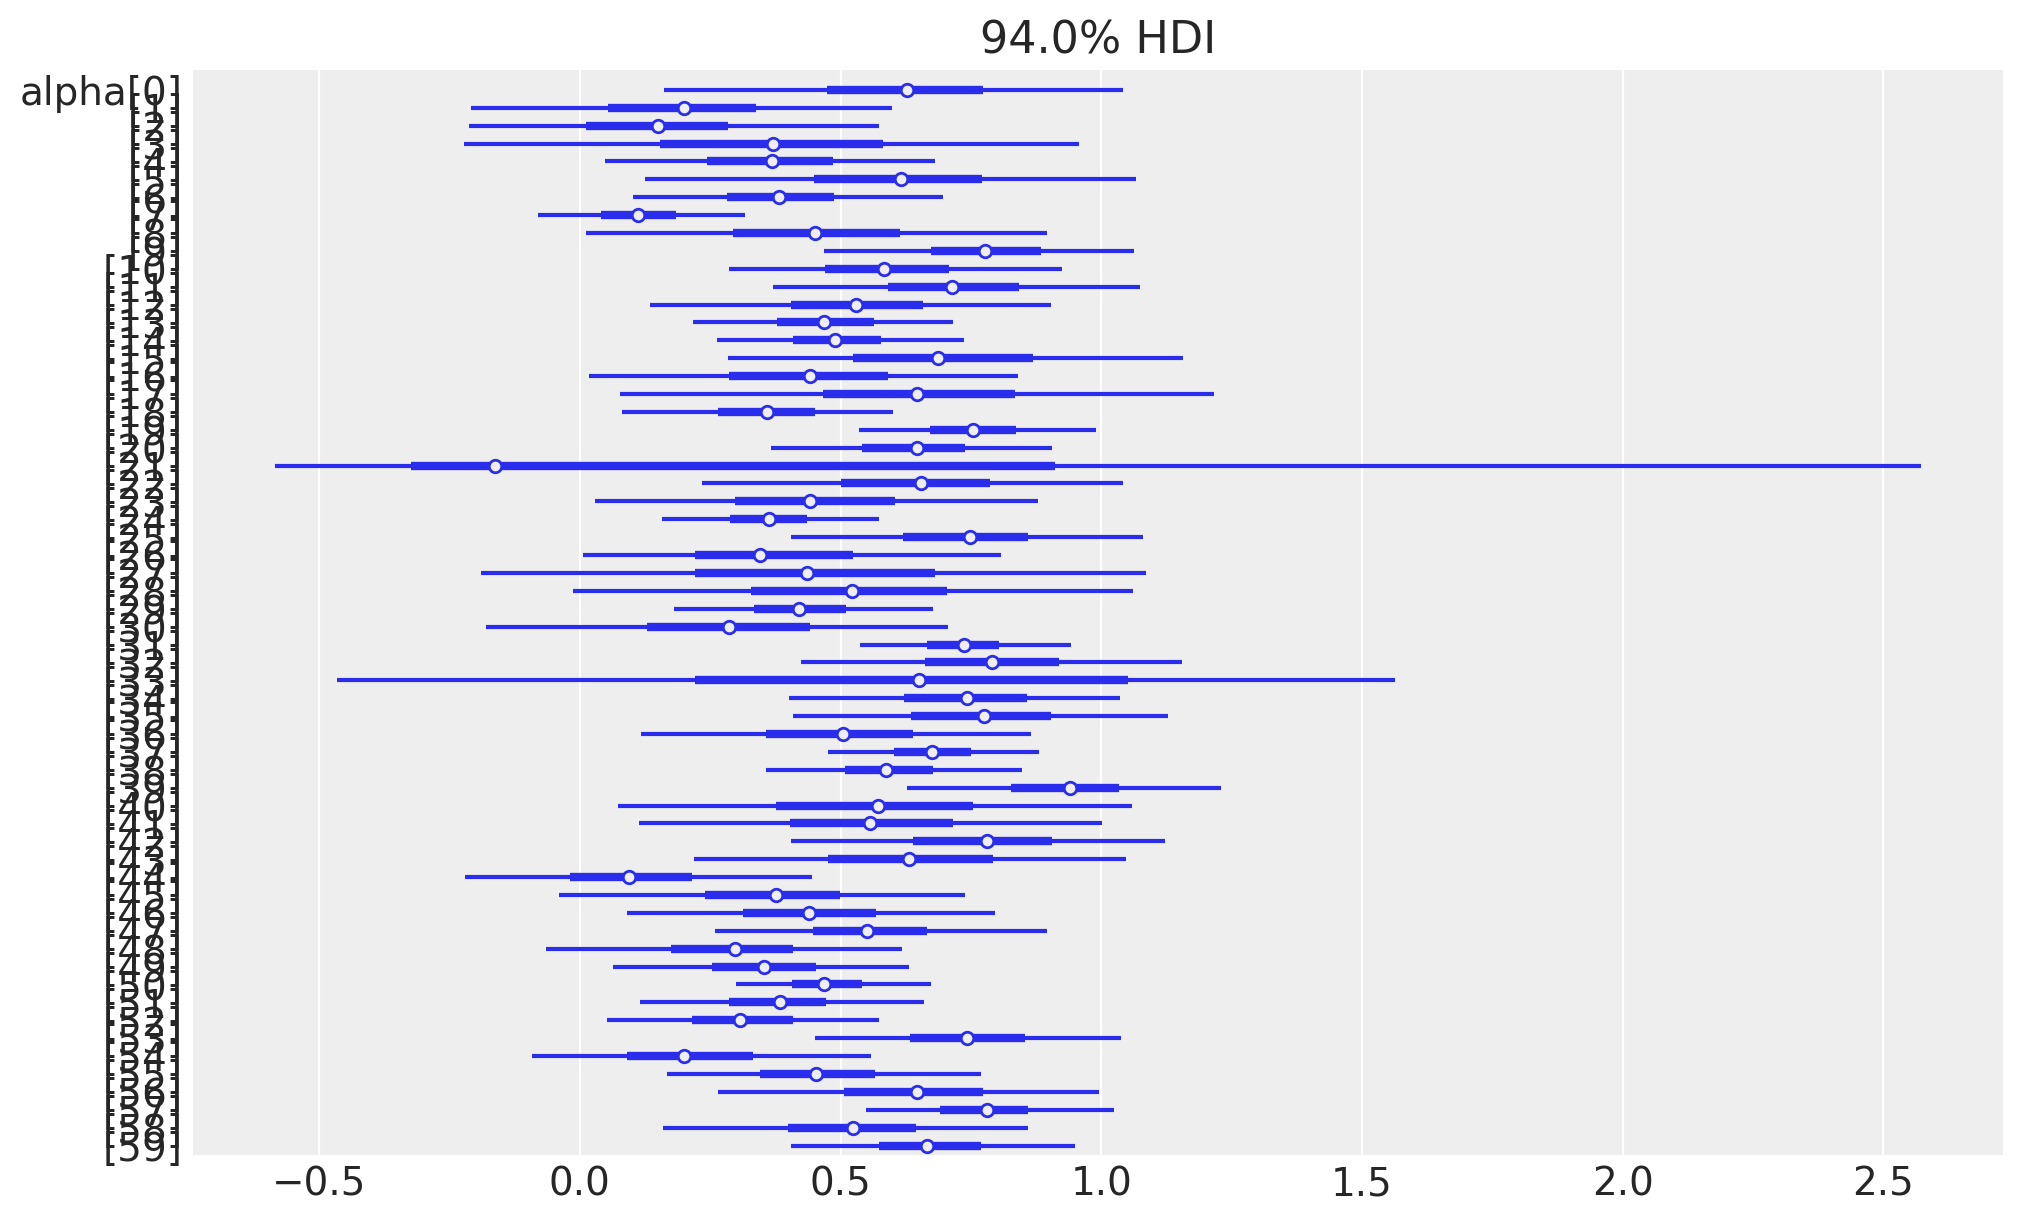

In [16]:
# Extract the alpha parameters only
alpha_params = fit_person_az.posterior["alpha"]

# Plot forest plot for alpha parameters
_ = az.plot_forest(
    alpha_params,
    hdi_prob=0.94,  # Set the credible interval to 94%
    combined=True,  # Combine the chains if there are multiple
    r_hat=False,  # Display the r_hat values
    figsize=(10, 6),
)

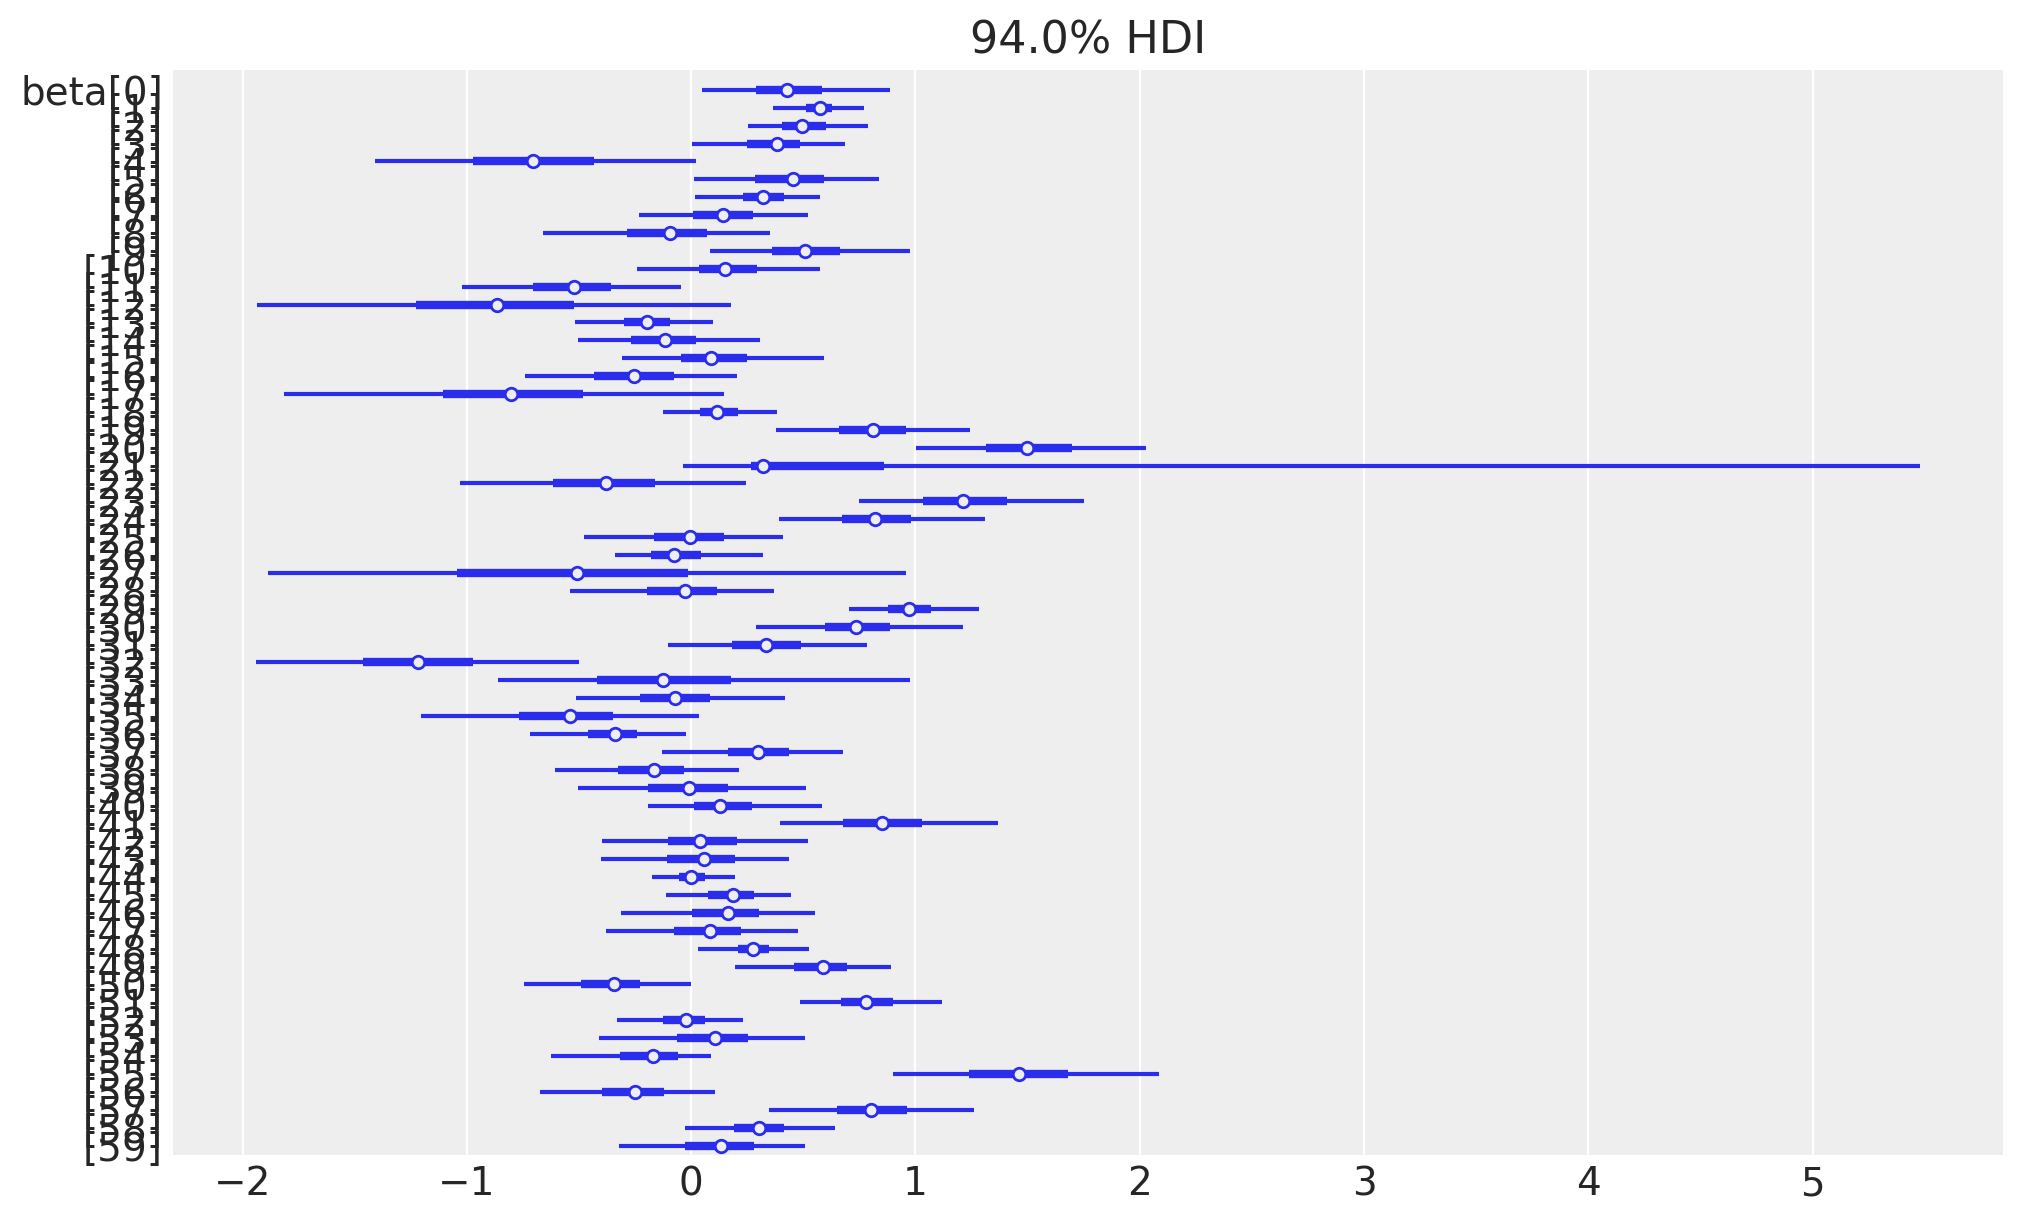

In [17]:
# Extract the beta parameters only
beta_params = fit_person_az.posterior["beta"]

# Plot forest plot for beta parameters
_ = az.plot_forest(
    beta_params,
    hdi_prob=0.94,  # Set the credible interval to 94%
    combined=True,  # Combine the chains if there are multiple
    r_hat=False,  # Display the r_hat values
    figsize=(10, 6),
)

Come si può vedere, c'è eterogeneità tra i partecipanti sia per α che per β. Il pannello di destra mostra i parametri α e β di ciascun partecipante rappresentati graficamente l'uno contro l'altro, con le croci che indicano gli intervalli credibili per ciascun parametro.

## Modello Gerarchico

Sebbene la stima dei parametri a livello individuale offra vantaggi rispetto al modello a livello di campione, presenta anche alcune limitazioni. Un problema del modello a livello di persona è che rende difficile fare inferenze sulla popolazione da cui provengono i partecipanti. Analizzare un modello a livello individuale è simile a eseguire un'analisi separata per ciascun partecipante del campione. Questo approccio ha una potenza inferiore perché considera i dati di un solo partecipante alla volta, ignorando il resto del campione. Inoltre, non riesce a catturare le somiglianze tra gli individui che potrebbero derivare dal fatto che i partecipanti appartengono alla stessa popolazione.

Spesso i ricercatori desiderano esaminare la variazione tra i partecipanti e, al contempo, fare inferenze sulla popolazione nel suo complesso. Un approccio di modellizzazione gerarchica è estremamente utile a questo scopo. I modelli bayesiani gerarchici permettono ai ricercatori di modellare simultaneamente i livelli individuali e quello di popolazione.

Come nel modello a livello individuale, il modello gerarchico stima parametri unici per ogni individuo. Tuttavia, a differenza del modello a livello individuale, l'approccio gerarchico modella anche la distribuzione dei parametri a livello individuale nella popolazione generale. Di conseguenza, i parametri a livello individuale sono influenzati non solo dai dati di quel singolo individuo, ma anche dalla distribuzione a livello di popolazione del parametro rilevante, riducendo l'influenza degli outlier sulle stime dei parametri.

Compiliamo e stampiamo il modello `3_hierarchical_model.stan`.

In [18]:
stan_file = os.path.join(
    project_directory, "stan", "change_models", "3_hierarchical_model.stan"
)

hierarchical_model = CmdStanModel(stan_file=stan_file)
print(hierarchical_model.code())

data {
  int<lower=0> Ntotal; // Total number of trials in the dataset (600)
  array[Ntotal] int<lower=1> trial; // Trial number
  array[Ntotal] real observed_goal; // Goal level for each trial
  array[Ntotal] real performance; // Performance for each trial
  int<lower=1> Nsubj; // Number of subjects
  array[Ntotal] int<lower=1, upper=Nsubj> subject; // Subject number
}
parameters {
  vector[Nsubj] alpha; // Unique alpha parameter for each subject
  vector[Nsubj] beta; // Unique beta parameter for each subject
  real<lower=0> sigma; // Single sigma parameter for entire sample
  real alpha_mean; // Population mean parameter for the alpha distribution
  real<lower=0> alpha_sd; // Population sd parameter for the alpha distribution
  real beta_mean; // Population mean parameter for the beta distribution
  real<lower=0> beta_sd; // Population sd parameter for the beta distribution
}
model {
  vector[Ntotal] predicted_goal; // Vector to store predictions
  
  // Priors
  alpha ~ normal(alpha

Nel modello gerarchico, aggiungiamo nuovi parametri per catturare meglio la variabilità tra i partecipanti e fare inferenze più robuste sulla popolazione. I parametri `alpha_mean` e `alpha_sd` descrivono la distribuzione di `alpha` a livello di popolazione, mentre `beta_mean` e `beta_sd` fanno lo stesso per `beta`. Questo approccio ci permette di non trattare ogni partecipante isolatamente, ma di considerare anche come i loro parametri individuali si distribuiscono all'interno della popolazione.

I priori in questo modello differiscono dagli altri perché, anziché essere generici e non informativi, si basano sui parametri a livello di popolazione. Quindi, ogni parametro a livello individuale viene stimato tenendo conto della distribuzione a livello di popolazione, rendendo le stime meno sensibili a dati estremi o anomali. Questo approccio ci fornisce una comprensione più dettagliata e accurata di come i parametri variano sia tra gli individui che nella popolazione complessiva.

Eseguiamo il campionamento.

In [19]:
fit_hierarchical = hierarchical_model.sample(
    data=stan_data,
    iter_warmup=5_000,
    iter_sampling=10_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

In [20]:
fit_hierarchical_az = az.from_cmdstanpy(posterior=fit_hierarchical)
az.summary(fit_hierarchical_az, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.54,0.14,0.28,0.80,0.0,0.0,48765.44,31528.85,1.0
alpha[1],0.38,0.13,0.13,0.63,0.0,0.0,44672.18,29684.11,1.0
alpha[2],0.33,0.12,0.10,0.56,0.0,0.0,30957.20,30389.86,1.0
alpha[3],0.47,0.15,0.20,0.75,0.0,0.0,49280.74,29994.33,1.0
alpha[4],0.36,0.12,0.14,0.58,0.0,0.0,29036.20,28050.90,1.0
...,...,...,...,...,...,...,...,...,...
predicted_goal[596],6.28,0.30,5.73,6.86,0.0,0.0,61708.74,29589.38,1.0
predicted_goal[597],6.87,0.30,6.29,7.43,0.0,0.0,63110.37,31074.04,1.0
predicted_goal[598],6.51,0.32,5.91,7.13,0.0,0.0,58823.98,28862.76,1.0
predicted_goal[599],6.38,0.33,5.76,7.01,0.0,0.0,58004.34,29837.65,1.0


Esaminiamo le stime a posteriori di $\alpha$ e $\beta$ per ciascun partecipante.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

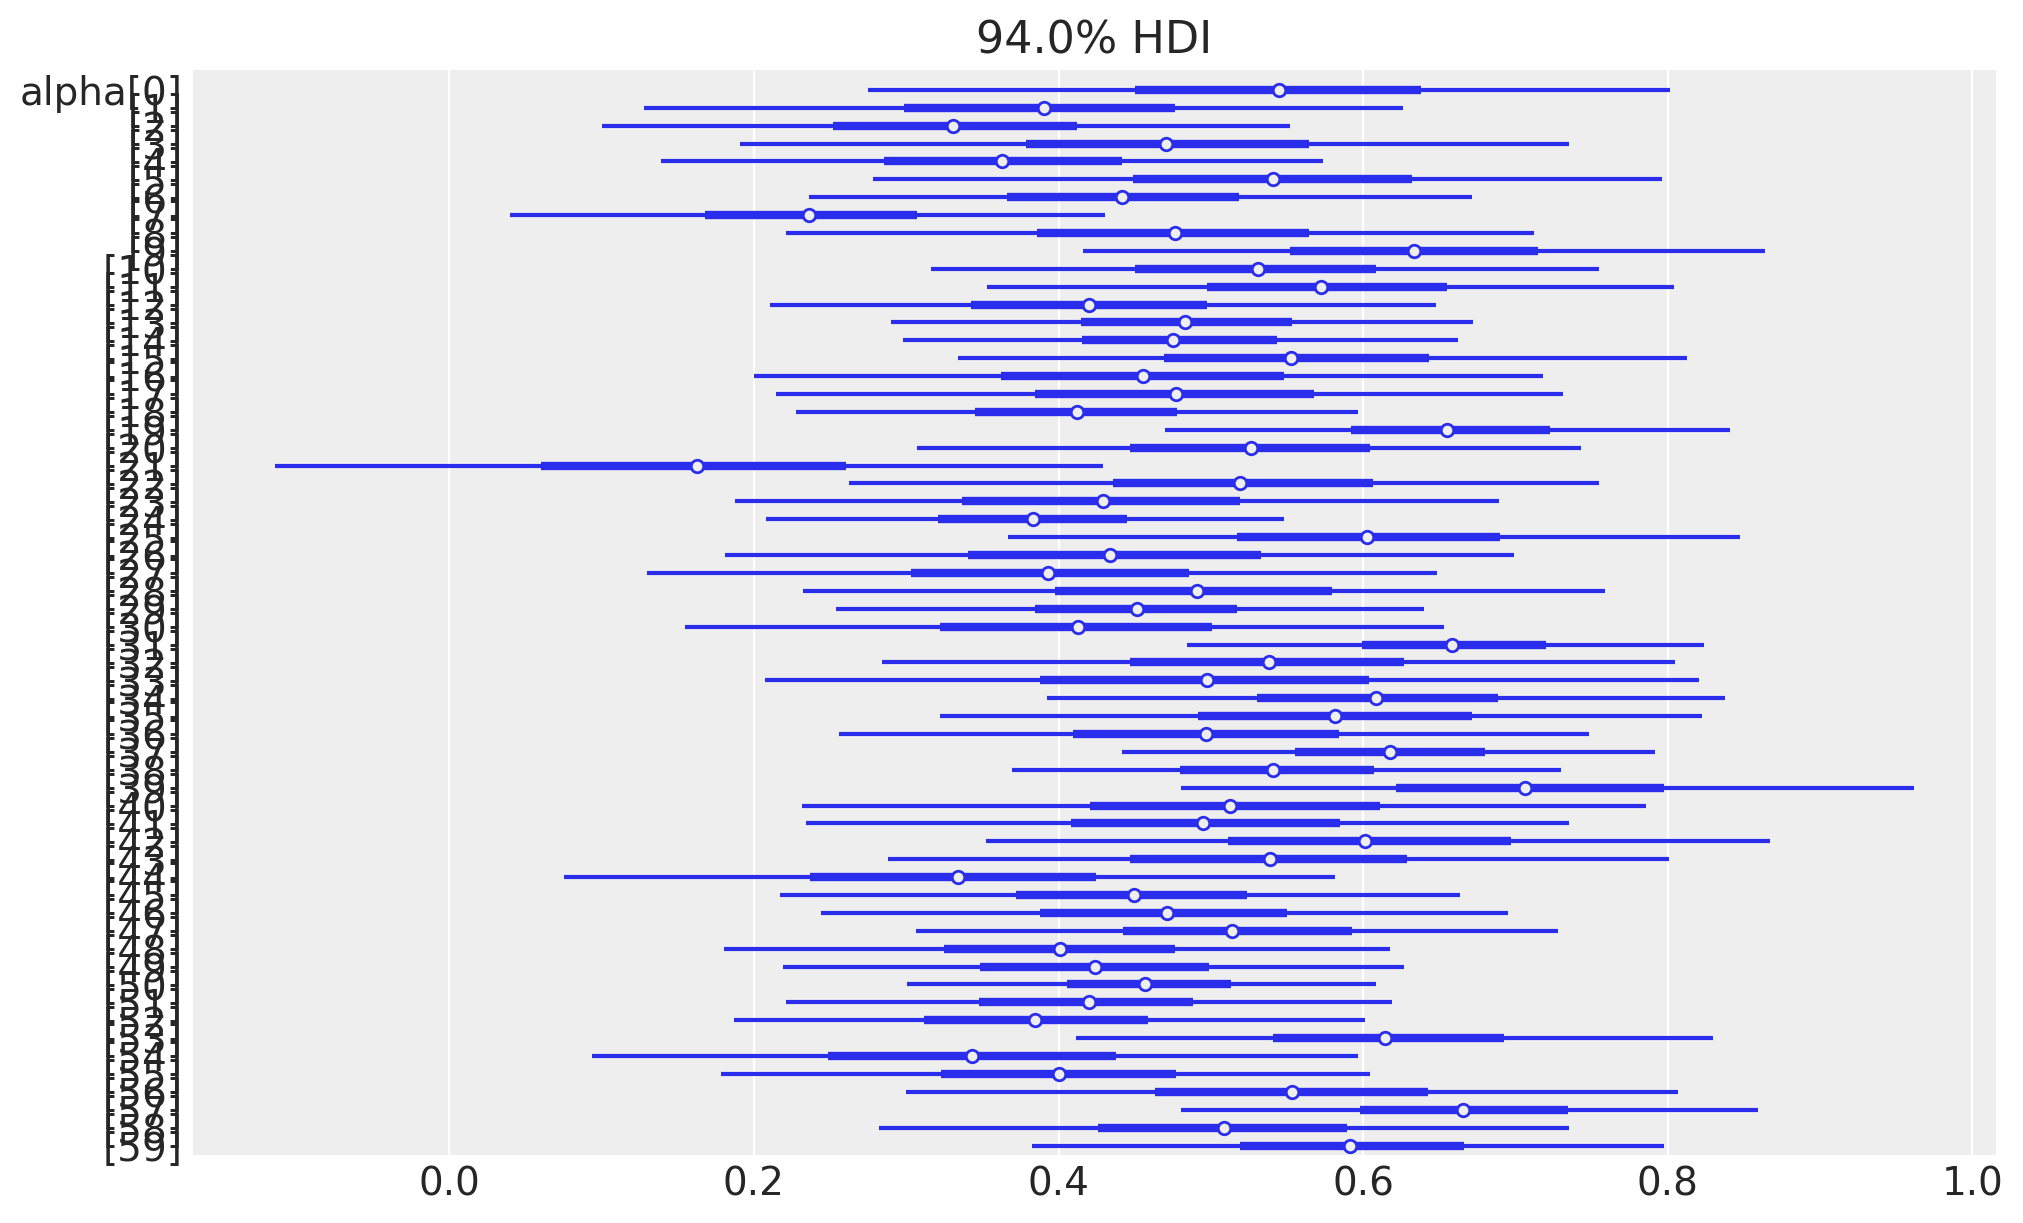

In [37]:
# Extract the alpha parameters only
alpha_params = fit_hierarchical_az.posterior["alpha"]

# Plot forest plot for alpha parameters
az.plot_forest(
    alpha_params,
    hdi_prob=0.94,  # Set the credible interval to 94%
    combined=True,  # Combine the chains if there are multiple
    r_hat=False,  # Display the r_hat values
    figsize=(10, 6),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

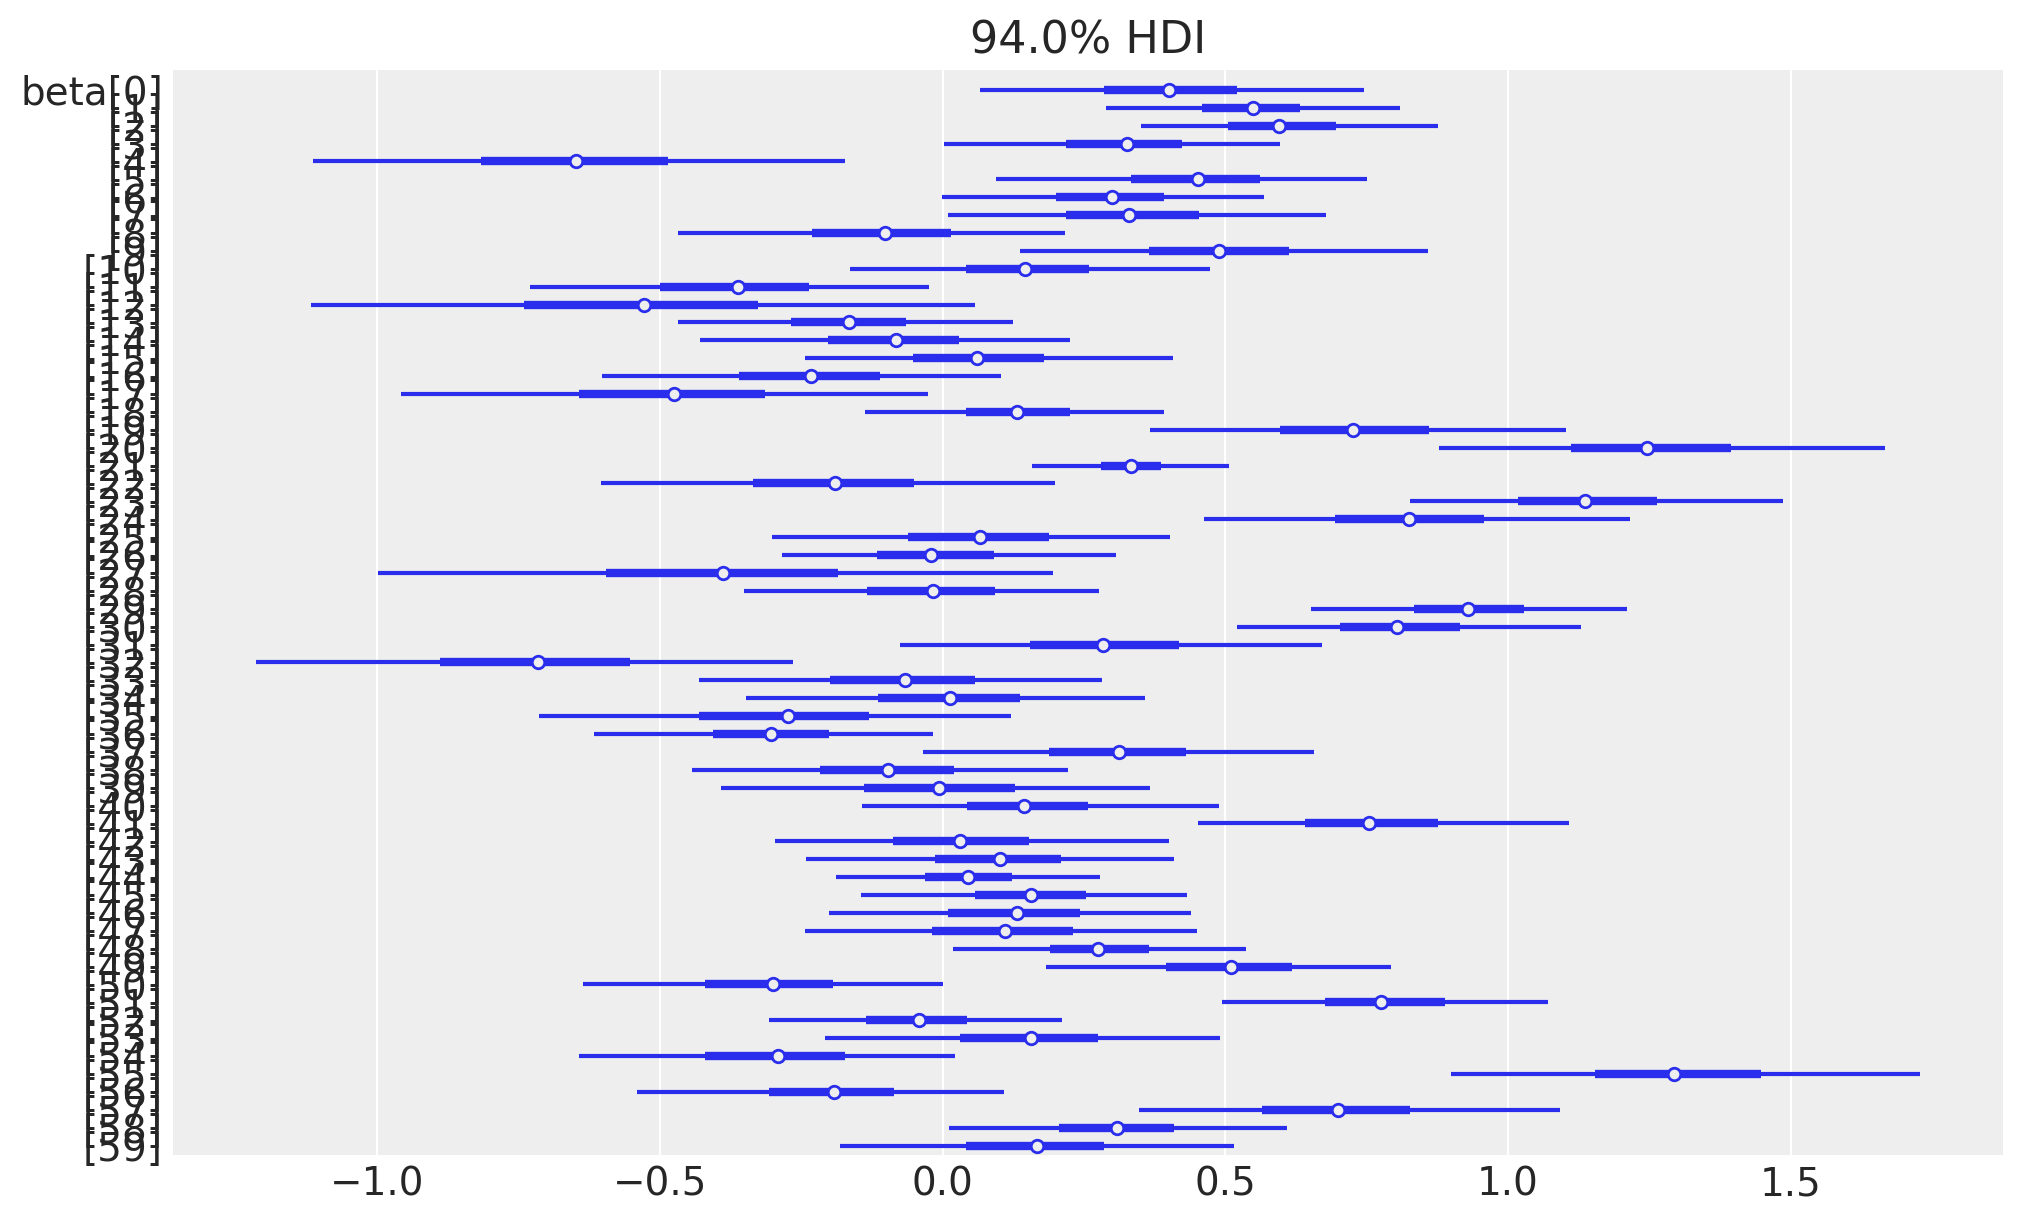

In [38]:
# Extract the alpha parameters only
beta_params = fit_hierarchical_az.posterior["beta"]

# Plot forest plot for alpha parameters
az.plot_forest(
    beta_params,
    hdi_prob=0.94,  # Set the credible interval to 94%
    combined=True,  # Combine the chains if there are multiple
    r_hat=False,  # Display the r_hat values
    figsize=(10, 6),
)

Si osserva che gli intervalli credibili dei parametri a livello individuale sono meno dispersi nel modello gerarchico rispetto al modello a livello individuale. Questo avviene perché, nel modello gerarchico, la distribuzione a livello di popolazione impone un vincolo aggiuntivo sui parametri a livello individuale, spingendo questi parametri verso la media del gruppo. Questo fenomeno è noto come "shrinkage" o "contrazione".

Oltre ai parametri $\alpha$ e $\beta$ per ciascun soggetto, il modello gerarchico stima anche gli iperparametri `alpha_mean` e `beta_mean`, oltre a `alpha_sd`, `beta_sd` e `sigma`.

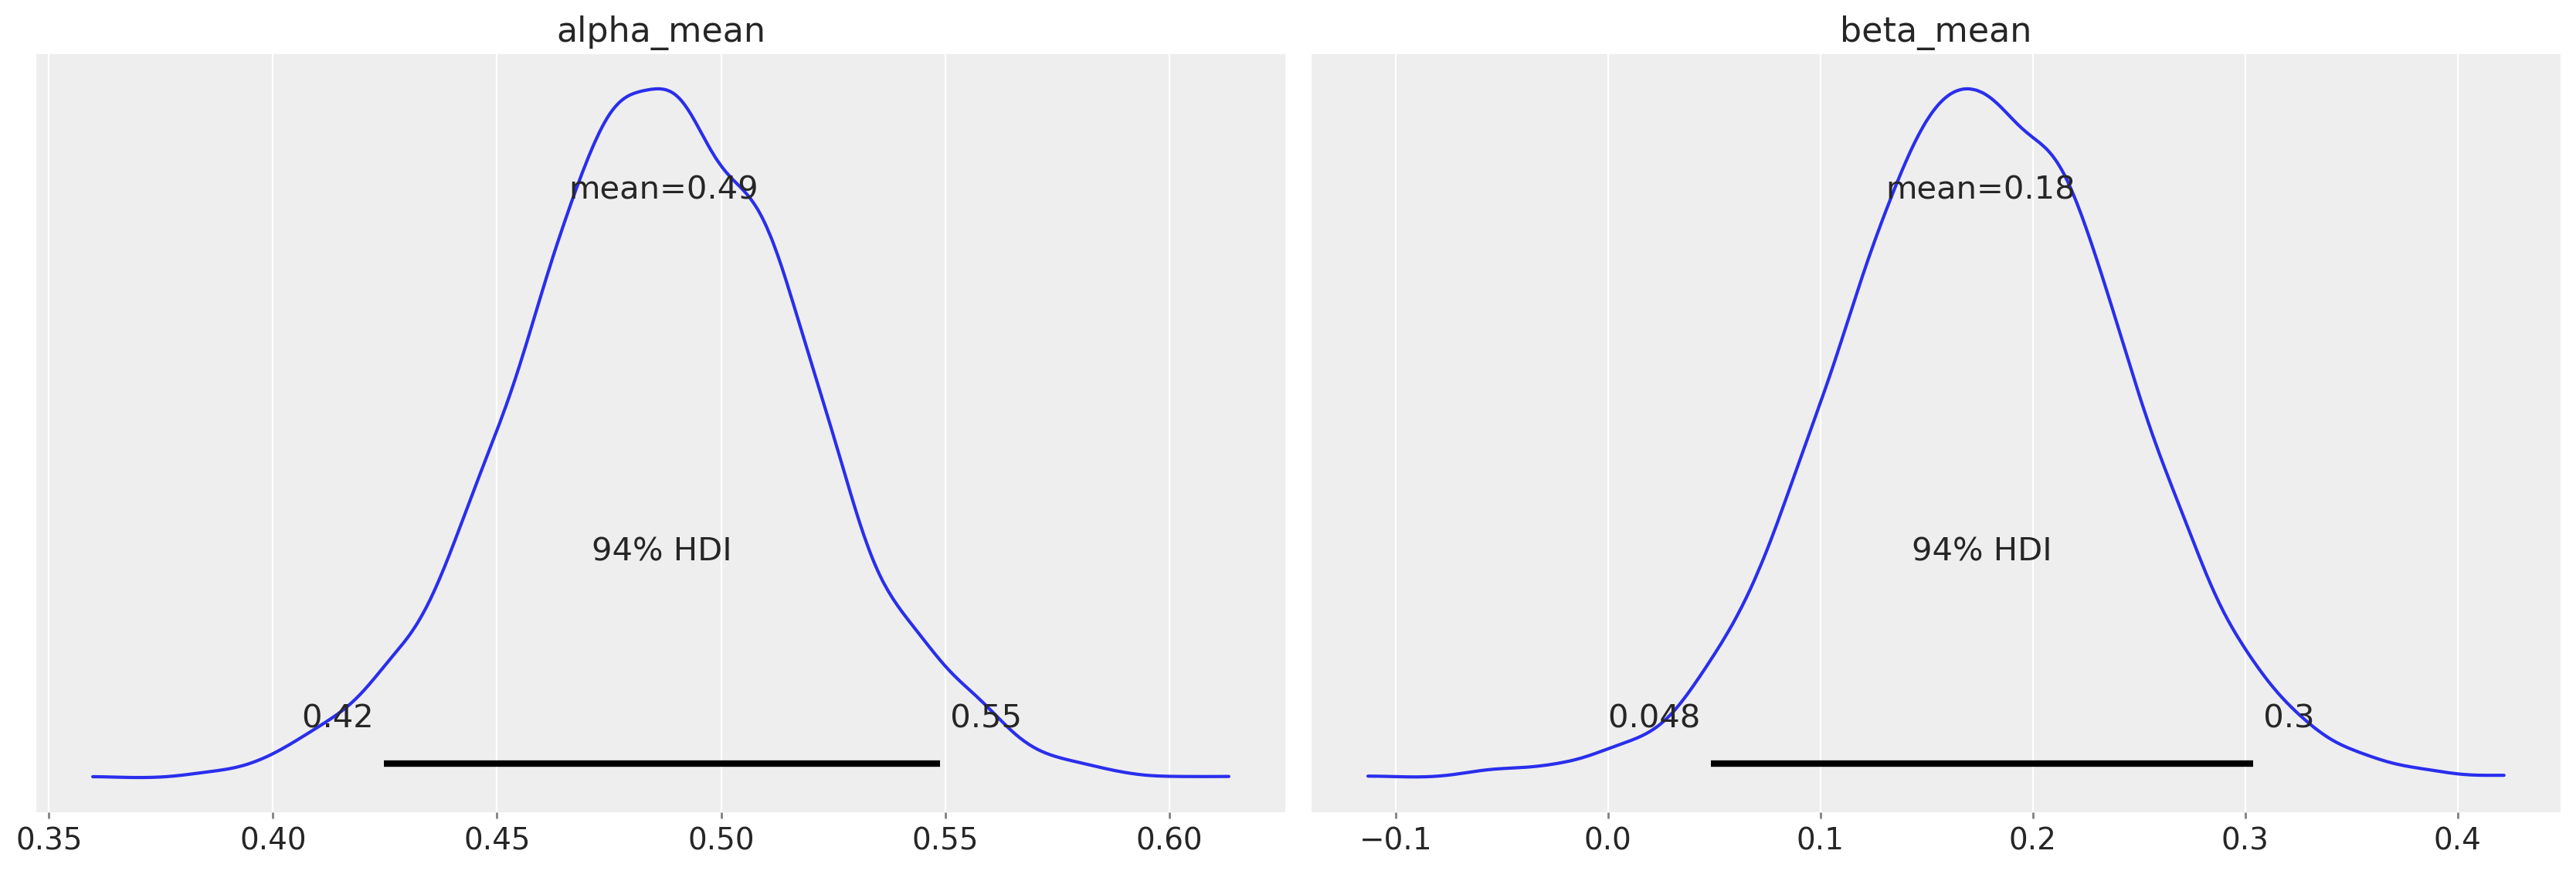

In [41]:
_ = az.plot_posterior(fit_hierarchical, var_names=["alpha_mean", "beta_mean"])

Il modello gerarchico utilizza `alpha_mean` e `beta_mean` per rappresentare le tendenze generali a livello di popolazione. Questi parametri ci danno un'idea di come, mediamente, i partecipanti aggiornano i loro obiettivi sulla base delle performance passate e indipendentemente da esse. 

- `alpha_mean` riflette quanto i partecipanti, in media, siano influenzati dalla differenza tra la performance passata e l'obiettivo previsto quando aggiornano il loro obiettivo.
- `beta_mean` riflette l'incremento medio fisso che i partecipanti aggiungono al loro obiettivo, indipendentemente da altri fattori.

La stima di `alpha_mean` è 0.49, con un intervallo credibile del 94% che va da 0.42 a 0.55.
Questo parametro rappresenta la media della distribuzione di `alpha` a livello di popolazione. In altre parole, `alpha_mean` è il valore medio del parametro `alpha` considerando tutti i partecipanti del campione. In questo modello, `alpha` rappresenta la sensibilità di ogni partecipante alla differenza tra la performance precedente e l'obiettivo previsto. Un valore di `alpha_mean` di 0.49 suggerisce che, mediamente, i partecipanti tendono ad aggiornare il loro obiettivo basandosi per circa il 49% sulla differenza tra la performance precedente e l'obiettivo precedente. L'intervallo credibile, che va da 0.42 a 0.55, indica che c'è un'alta probabilità che la vera media della popolazione per `alpha` si trovi in questo range.

La stima di `beta_mean` è 0.18, con un intervallo credibile del 94% che va da 0.048 a 0.3.
`beta_mean` rappresenta la media della distribuzione di `beta` a livello di popolazione. In questo contesto, `beta` indica un incremento additivo costante nell'obiettivo del partecipante, indipendentemente dalla differenza tra la performance precedente e l'obiettivo previsto. Un valore di `beta_mean` di 0.18 suggerisce che, mediamente, i partecipanti tendono ad aumentare il loro obiettivo di un piccolo valore fisso (circa 0.18) in ogni prova, indipendentemente dalle altre variabili. L'intervallo credibile da 0.048 a 0.3 indica che c'è un'alta probabilità che il vero valore medio di `beta` nella popolazione si trovi in questo intervallo.

In sintesi, questi parametri aiutano a comprendere il comportamento generale dei partecipanti rispetto all'aggiornamento degli obiettivi, catturando sia l'adattamento dinamico in base alle performance precedenti che un aggiustamento incrementale costante.

## Valutazione e Confronto di Modelli

Una volta che il ricercatore ha specificato un modello appropriato e verificato che il modello ottiene la convergenza, può valutare se il modello descrive adeguatamente i dati. Le stime dei parametri sono interpretabili solo nella misura in cui il modello rappresenta accuratamente il fenomeno che si sta indagando. Se il modello approssima male i dati, le informazioni contenute nelle stime dei parametri potrebbero non essere rappresentative del processo che il ricercatore sta cercando di analizzare. In tali casi, potrebbe essere necessario riformulare il modello per migliorare la sua capacità di spiegare le osservazioni empiriche.

In [89]:
# Run diagnostics and print results
diagnostic_info = fit_sample.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/1_sample_level_modelh2kv1c5m/1_sample_level_model-20240824092852_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/1_sample_level_modelh2kv1c5m/1_sample_level_model-20240824092852_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/1_sample_level_modelh2kv1c5m/1_sample_level_model-20240824092852_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/1_sample_level_modelh2kv1c5m/1_sample_level_model-20240824092852_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [90]:
# Run diagnostics and print results
diagnostic_info = fit_person.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/2_person_level_model3rm_zhgj/2_person_level_model-20240824085216_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/2_person_level_model3rm_zhgj/2_person_level_model-20240824085216_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/2_person_level_model3rm_zhgj/2_person_level_model-20240824085216_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/2_person_level_model3rm_zhgj/2_person_level_model-20240824085216_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
11074 of 80000 (13.84%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions

In [91]:
# Run diagnostics and print results
diagnostic_info = fit_hierarchical.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/3_hierarchical_modelq19mwkng/3_hierarchical_model-20240824085700_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/3_hierarchical_modelq19mwkng/3_hierarchical_model-20240824085700_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/3_hierarchical_modelq19mwkng/3_hierarchical_model-20240824085700_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp8aprzkhg/3_hierarchical_modelq19mwkng/3_hierarchical_model-20240824085700_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
27 of 40000 (0.07%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC

Si noti che sia il modello a livello di persona che il modello gerarchico mostrano dei problemi indicati dalla presenza di transizioni divergenti, anche se il modello gerarchico è meno problematico di quello basato sulle stime dei coefficienti delle persone soltanto. 

Eseguiamo comunque il calcolo dei valori k di Pareto e la validazione incrociata Leave-One-Out (LOO-CV) utilizzando ArviZ.

In [86]:
loo_person_result = az.loo(fit_person_az)
print(loo_person_result)

Computed from 80000 posterior samples and 600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -920.94    57.89
p_loo      201.15        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      543   90.5%
 (0.5, 0.7]   (ok)         39    6.5%
   (0.7, 1]   (bad)        12    2.0%
   (1, Inf)   (very bad)    6    1.0%



In [87]:
loo_hierarchical_result = az.loo(fit_hierarchical_az)
print(loo_hierarchical_result)

Computed from 40000 posterior samples and 600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -842.54    36.72
p_loo       95.53        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      583   97.2%
 (0.5, 0.7]   (ok)         13    2.2%
   (0.7, 1]   (bad)         2    0.3%
   (1, Inf)   (very bad)    2    0.3%



C'è un piccolo numero di valori di Pareto $k$  problematici, i quali indicando che vi sono delle osservazioni che hanno un'influenza eccessiva sulle stime del modello. Tali problemi andrebbero affrontati prima di calcolare l'ELPD. Per gli scopi di questo tutorial, tuttavia, procediamo tenendo comunque a mente la possibilità che la stima dell'ELPD possa essere distorta. 

Infine, calcoliamo la differenza tra le stime dell'ELPD (`elpd_diff`) dei due modelli. L'incertezza associata a questa differenza è espressa dal suo errore standard (`dse`). Se il rapporto tra `elpd_diff` e `dse` è pari o superiore a 2, possiamo concludere che esiste una differenza credibile tra i due modelli.

In [88]:
df_comp_loo = az.compare({
    "person_model": loo_person_result, 
    "hierarchical_model": loo_hierarchical_result
})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical_model,0,-842.541615,95.525862,0.000000,0.907237,36.718759,0.000000,True,log
person_model,1,-920.935304,201.145350,78.393688,0.092763,57.891756,43.516941,True,log


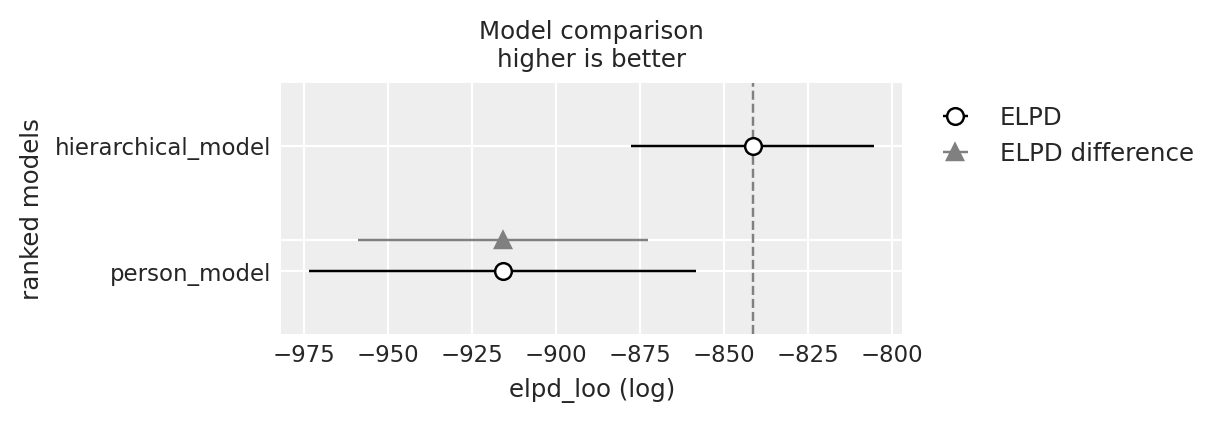

In [22]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

Il rapporto tra `elpd_diff` e `dse` è leggermente inferiore a 2, il che suggerisce una debole evidenza a favore del modello gerarchico rispetto al modello non gerarchico, basandosi sul confronto dell'ELPD dei due modelli. Tuttavia, il modello non gerarchico presenta notevoli problemi con i valori di Pareto $k$, portando alla conclusione che, complessivamente, il modello gerarchico sia da preferire.

Prima di giungere a una conclusione definitiva, ci sarebbero vari problemi da affrontare. Tuttavia, per gli scopi di questo tutorial, non è necessario entrare nei dettagli, poiché l'obiettivo principale è introdurre un modello dinamico, mostrare come questo modello possa rappresentare le differenze individuali e spiegare perché un modello gerarchico possa essere più appropriato rispetto a un modello che stima i parametri dei partecipanti separatamente.

@knight2023tutorial approfondiscono ulteriormente la descrizione di questi dati discutendo due ulteriori modelli: un modello che distingue l'appartenenza a gruppi distinti identificabili in modo esplicito e un modello a mescolanza. A volte, il ricercatore conosce in anticipo il gruppo a cui appartiene ogni partecipante. Tuttavia, ciò non è sempre il caso. In alcune situazioni, il ricercatore potrebbe voler identificare sottogruppi di partecipanti che mostrano comportamenti simili, senza alcuna conoscenza preliminare dell'appartenenza ai gruppi. Per fare ciò, si può utilizzare un modello a mescolanza, un modello che serve a catturare comportamenti risultanti da processi differenti. Ad esempio, potrebbe esserci un sottogruppo di partecipanti che si comporta secondo un processo e un altro sottogruppo il cui comportamento è governato da un processo diverso. Questi diversi processi sono definiti "mescolanze". L'obiettivo dell'analisi è determinare i parametri che meglio caratterizzano ciascuna mescolanza e fare inferenze sull'influenza relativa di ciascuna mescolanza sul comportamento di ogni partecipante.

Anche se questi modelli migliorano la descrizione dei dati di questo campione, per gli scopi del presente tutorial non sono necessari.



## Riflessioni Conclusive

Le teorie dinamiche, pur essendo influenti in psicologia, sono spesso difficili da verificare. Testare una teoria dinamica richiede un modello statistico che rifletta accuratamente i processi descritti dalla teoria stessa. In questo capitolo, seguendo il tutorial di @knight2023tutorial, abbiamo esaminato un approccio bayesiano alla modellizzazione dei processi dinamici. Per illustrare questa flessibilità, @knight2023tutorial considerano un modello di revisione degli obiettivi pubblicato da @gee2018formal. Una caratteristica importante di questo modello, comune a molte teorie dinamiche, è l'assunzione che alcune variabili abbiano una sorta di "memoria". La capacità di rappresentare variabili dinamiche come queste è fondamentale per testare teorie che presumono processi di feedback ricorsivi, tipici di molte teorie influenti.

L'approccio bayesiano affronta questo problema e offre un modo intuitivo per implementare modelli complessi di processi dinamici. In questo capitolo abbiamo iniziato con un modello a livello di campione, che quantifica l'incertezza nei valori medi dei parametri del modello di revisione degli obiettivi per tutti i partecipanti. Successivamente, abbiamo mostrato come estendere questo framework per creare modelli più sofisticati che catturano la variabilità tra individui e gruppi. Il modello a livello individuale quantifica i componenti del processo di revisione degli obiettivi separatamente per ogni individuo. Infine, il modello gerarchico combina i modelli a livello di campione e a livello individuale in un unico framework, consentendo di quantificare i componenti separatamente per ogni individuo e di fare inferenze a livello di popolazione.

@knight2023tutorial discutono altri modelli qui non considerati, come il modello a gruppi multipli, che quantifica le differenze nei componenti del processo tra gruppi noti (ad esempio, diversi livelli di una manipolazione sperimentale) e il modello a mescolanza, che consente al ricercatore di identificare sottogruppi latenti di partecipanti per i quali il processo dinamico si svolge in modo simile.

I modelli che abbiamo introdotto in questo capitolo rappresentano solo una piccola parte della vasta gamma di modelli che possono essere implementati utilizzando questo framework. La flessibilità di questo approccio permette di creare modelli con praticamente qualsiasi forma funzionale, offrendo ai ricercatori la possibilità di sviluppare modelli personalizzati che rappresentano più accuratamente la teoria che si sta testando rispetto ai modelli generici disponibili.

In conclusione, le teorie dinamiche, comuni in psicologia, possono essere difficili da testare perché i processi che le sottendono sono spesso troppo complessi per essere adeguatamente rappresentati nei modelli statistici tradizionali.  L'approccio bayesiano che @knight2023tutorial illustrano nel loro tutorial consente di superare queste sfide, offrendo un modo flessibile per sviluppare, testare e confrontare modelli dinamici. Questo approccio offre ai ricercatori la possibilità di rappresentare meglio fenomeni dinamici o gerarchici, in cui i processi possono variare nel tempo, a diversi livelli e in diversi contesti e per diverse persone.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sat Jul 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pingouin  : 0.5.4
logging   : 0.5.1.2
numpy     : 1.26.4
arviz     : 0.18.0
cmdstanpy : 1.2.3
matplotlib: 3.8.4
pandas    : 2.2.2
scipy     : 1.13.1

Watermark: 2.4.3

